# Prep

In [15]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
import torch.nn.functional as F

In [16]:
from Inception import ClassifierInception
from ConformerClassifier import ConformerClassifier
from EmformerClassifier import EmformerClassifier
#from experiments import perform_test
from data_preparation import gen_files

In [17]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [18]:
train_dir = r"C:\Users\rafci\Desktop\tensorflow-speech-recognition-challenge\train"
if not os.path.exists(train_dir):
    train_dir = r"C:\Users\jakub\Desktop\PD\sem10\deep\tensorflow-speech-recognition-challenge\train"

In [20]:
# gen_files(train_dir)

In [6]:
X_train = np.load("data/X_train.npy")
y_train = np.load("data/y_train.npy")

X_val = np.load("data/X_val.npy")
y_val = np.load("data/y_val.npy")

X_train = X_train.reshape((-1, X_train.shape[1], X_train.shape[2]))
X_val = X_val.reshape((-1, X_val.shape[1], X_val.shape[2]))

classes = os.listdir(train_dir+'/audio/')

def convert_list_dict(lst):
    res_dct = {i: val for i, val in enumerate(lst)}
    return res_dct
         
classes_index = convert_list_dict(classes)

In [7]:
INPUT_SHAPE = (85, 122)
NB_CLASSES = len(classes)

In [8]:
y_train = torch.tensor(y_train).long()
y_val = torch.tensor(y_val).long()
X_train = torch.tensor(X_train)
X_val = torch.tensor(X_val)

y_train = F.one_hot(y_train, num_classes = NB_CLASSES)
#y_val = F.one_hot(y_val, num_classes = NB_CLASSES)

In [9]:
train_data = TensorDataset(X_train.float().transpose(2, 1), y_train.float())
valid_data = TensorDataset(X_val.float().transpose(2, 1), y_val.float())

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

import torch
from torch.utils.data import DataLoader

RANDOM_SEED = 17
NUM_WORKERS = 0

COMMANDS = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', ]
VAL_CLASSES = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence']
CLASSES = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'unknown']

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

def perform_test(model, train_data, test_data, num_epochs, criterion, optimizer, batch_size, all_classes, device, scheduler = None, should_print = True, random_seed=RANDOM_SEED, trans_mode = False):
    generator = torch.Generator().manual_seed(random_seed)
    random.seed(random_seed)
    torch.manual_seed(random_seed)
    
    dataloader_train = DataLoader(train_data, batch_size = batch_size, shuffle = True, generator = generator, num_workers = NUM_WORKERS)

    model, total_loss_all, accs = run_network(model = model, 
                                        optimizer = optimizer, 
                                        criterion = criterion, 
                                        dataloader = dataloader_train,
                                        should_print = should_print,
                                        num_epochs = num_epochs,
                                        all_classes = all_classes,
                                        device = device,
                                        valid_data = test_data,
                                        scheduler = scheduler,
                                        trans_mode = trans_mode)
    
    # evaluating model
    if should_print:
        print_err(total_loss_all)
        
        print("Test eval:")
        _, _, acc = evaluate(model = model, dataset = test_data, device = device, all_classes = all_classes, trans_mode = trans_mode)
        accs.append(acc)

        plot_accs(accs)
        
        
    return model,

def run_network(model, criterion, optimizer, dataloader, num_epochs, device, scheduler, valid_data, all_classes, trans_mode, should_print = True, test_frequency = 1):
    total_loss = []
    accs = []
    model.train()

    for epoch in range(num_epochs):
        model.train()
        loss = 0
    
        for inputs, labels in dataloader:
            if(trans_mode):
                inputs = inputs.permute(0, 2, 1)

            if device == torch.device('cuda'):
                inputs = inputs.cuda()
                labels = labels.cuda()

            optimizer.zero_grad()
            
            outputs = model(inputs)

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            loss += loss.item()
    
        if (scheduler is not None):
            scheduler.step()
        
        # stats per epoch
        total_loss.append(loss)
        if should_print:
            print(f"Epoch [{epoch+1}/{num_epochs}], Train loss: {loss / len(dataloader):.4f}")

            if (epoch + 1) % test_frequency == 0 and (epoch + 1) < num_epochs:
                _, _, acc = evaluate(model = model, dataset = valid_data, device = device, long_mode = False, all_classes = all_classes, trans_mode = trans_mode)
                accs.append(acc)
                print(f"Test accuracy: {acc}")
                
        
    return model, total_loss, accs

def print_err(total_loss):
    total_loss_c = []
    for l in total_loss:
        l = l.cpu()
        l = l.detach().numpy()
        total_loss_c.append(l)

    plt.figure(figsize=(8, 6))
    plt.plot(range(0, len(total_loss_c)), total_loss_c) 
    plt.xlabel('epoch')
    plt.ylabel('error')
    plt.title('error in each epoch')
    
def evaluate(model, dataset, device, all_classes, trans_mode, long_mode = True):
    dataloader = DataLoader(dataset, batch_size = 100, num_workers = NUM_WORKERS)
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            if(trans_mode):
                inputs = inputs.permute(0, 2, 1)

            if device == torch.device('cuda'):
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = model(inputs)

            inputs = inputs.cpu()
            labels = labels.cpu()
            outputs = outputs.cpu()

            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())

    # converting classes
    # class_dict = dict(all_classes)
    # y_true = np.array([class_dict[num] if class_dict.get(num) in VAL_CLASSES else "unknown" for num in y_true])
    # y_pred = np.array([class_dict[num] if class_dict.get(num) in VAL_CLASSES else "unknown" for num in y_pred])

    # class_to_number = {class_name: i for i, class_name in enumerate(CLASSES)}

    # y_true = np.array([class_to_number[class_dict[num]] if class_dict.get(num) in CLASSES else -1 for num in y_true])
    # y_pred = np.array([class_to_number[class_dict[num]] if class_dict.get(num) in CLASSES else -1 for num in y_pred])

    #target_names = [CLASSES[cls] for cls in range(12)]

    acc = accuracy_score(y_true = y_true, y_pred = y_pred)
    if long_mode:
        print(classification_report(y_true = y_true, 
                                    y_pred = y_pred, 
                                    #target_names = target_names,
                                    digits=4))

        cm = confusion_matrix(y_true = y_true, y_pred = y_pred)
            
        disp = ConfusionMatrixDisplay(confusion_matrix = cm, #display_labels = target_names
                                      )
        disp.plot()  
        
    return y_pred, y_true, acc

def plot_accs(accs):
    epochs = range(1, len(accs) + 1)

    plt.plot(epochs, accs, 'bo')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

### params

In [11]:
num_epochs = 10
batch_size = 64
lr = 0.0005
weight_decay = 1e-8

In [12]:
# trans params
num_heads=5
ffn_dim=256
num_layers = 4
dropout = 0

# inception params
num_filters = 32
use_residual = True
use_bottleneck = True
depth = 10
kernel_size = 41
bottleneck_size = 32 * 4

# Tests

## Model tests

### Inception test

In [25]:
model = ClassifierInception(INPUT_SHAPE, NB_CLASSES, num_filters, use_residual, use_bottleneck, depth, kernel_size, bottleneck_size)

model.to(DEVICE)
if DEVICE == torch.device('cuda'):
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)
scheduler = None

Epoch [1/10], Train loss: 0.0011
Test accuracy: 0.8616756835794707
Epoch [2/10], Train loss: 0.0008
Test accuracy: 0.8980845152800117
Epoch [3/10], Train loss: 0.0005
Test accuracy: 0.9137300774967101
Epoch [4/10], Train loss: 0.0006
Test accuracy: 0.9279134376370815
Epoch [5/10], Train loss: 0.0006
Test accuracy: 0.9270361163912852
Epoch [6/10], Train loss: 0.0004
Test accuracy: 0.9323000438660622
Epoch [7/10], Train loss: 0.0009
Test accuracy: 0.9311302822050007
Epoch [8/10], Train loss: 0.0004
Test accuracy: 0.9346395671881854
Epoch [9/10], Train loss: 0.0001
Test accuracy: 0.9344933469805528
Epoch [10/10], Train loss: 0.0001
Test eval:
              precision    recall  f1-score   support

         0.0     0.9009    0.9695    0.9340       197
         1.0     0.9800    0.9074    0.9423       162
         2.0     0.9422    0.9702    0.9560       168
         3.0     0.9691    0.9235    0.9458       170
         4.0     0.9715    0.9053    0.9373       264
         5.0     0.9703    

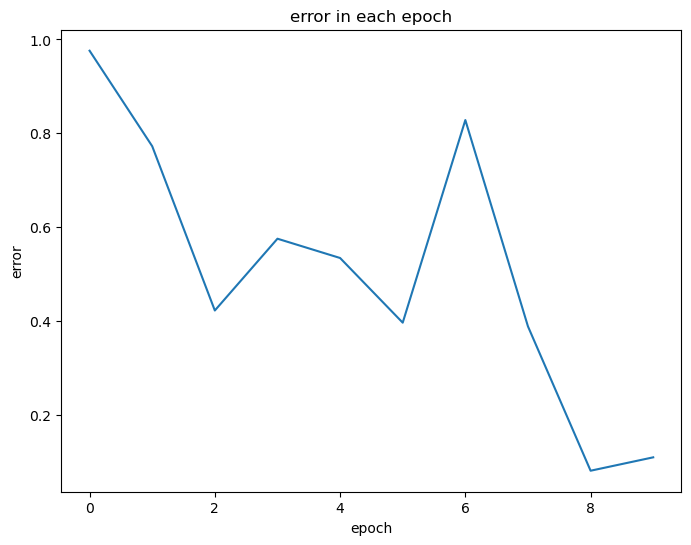

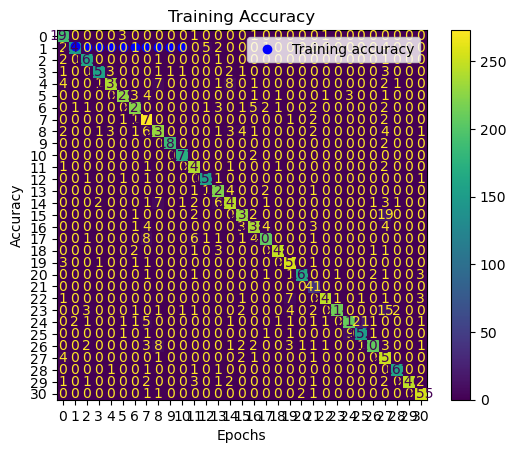

In [26]:
model = perform_test(model = model, 
                     train_data = train_data, 
                     test_data = valid_data, 
                     batch_size = batch_size, 
                     num_epochs = num_epochs, 
                     criterion = criterion, 
                     optimizer = optimizer, 
                     scheduler = scheduler,
                     device = DEVICE,
                     all_classes=classes_index,
                     trans_mode = False)

### Mod Inception test

In [ ]:
# TODO

### Conformer test

In [13]:
model = ConformerClassifier(num_classes = 31, input_length = INPUT_SHAPE[1], input_dim = INPUT_SHAPE[0], num_heads = num_heads, ffn_dim = ffn_dim, num_layers = num_layers, dropout = dropout)

model.to(DEVICE)
if DEVICE == torch.device('cuda'):
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)
scheduler = None

c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch [1/10], Train loss: 0.0008
Test accuracy: 0.8710337768679631
Epoch [2/10], Train loss: 0.0004
Test accuracy: 0.9093434712677292
Epoch [3/10], Train loss: 0.0003
Test accuracy: 0.9087585904371984
Epoch [4/10], Train loss: 0.0001
Test accuracy: 0.9137300774967101
Epoch [5/10], Train loss: 0.0005
Test accuracy: 0.9219184091241409
Epoch [6/10], Train loss: 0.0002
Test accuracy: 0.9181166837256909
Epoch [7/10], Train loss: 0.0004
Test accuracy: 0.9225032899546718
Epoch [8/10], Train loss: 0.0001
Test accuracy: 0.9206024272554467
Epoch [9/10], Train loss: 0.0001
Test accuracy: 0.9225032899546718
Epoch [10/10], Train loss: 0.0000
Test eval:


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


              precision    recall  f1-score   support

         0.0     0.9490    0.9442    0.9466       197
         1.0     0.9935    0.9506    0.9716       162
         2.0     0.9641    0.9583    0.9612       168
         3.0     0.9864    0.8529    0.9148       170
         4.0     0.8850    0.9621    0.9220       264
         5.0     0.9545    0.9506    0.9526       243
         6.0     0.9630    0.8595    0.9083       242
         7.0     0.8599    0.9643    0.9091       280
         8.0     0.9589    0.8077    0.8768       260
         9.0     1.0000    0.9788    0.9893       189
        10.0     0.9655    0.9711    0.9683       173
        11.0     0.9066    0.9433    0.9246       247
        12.0     0.9745    0.9563    0.9653       160
        13.0     0.9153    0.9391    0.9270       230
        14.0     0.8576    0.9370    0.8956       270
        15.0     0.8638    0.9414    0.9009       256
        16.0     0.8996    0.9066    0.9031       257
        17.0     0.8588    

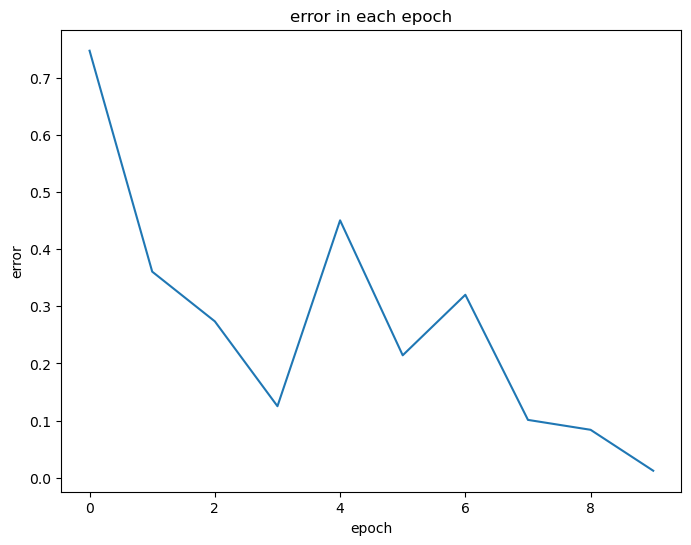

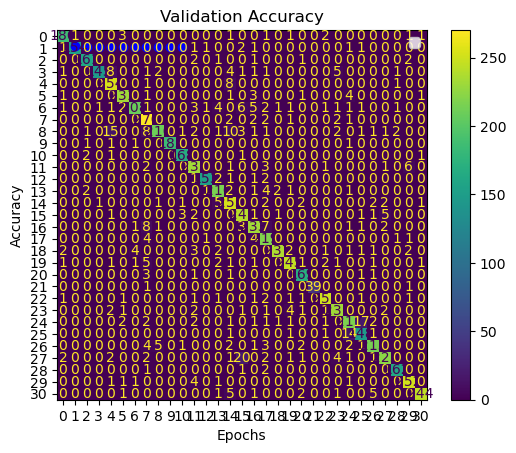

In [14]:
model = perform_test(model = model, 
                     train_data = train_data, 
                     test_data = valid_data, 
                     batch_size = batch_size, 
                     num_epochs = num_epochs, 
                     criterion = criterion, 
                     optimizer = optimizer, 
                     scheduler = scheduler,
                     device = DEVICE,
                     all_classes = classes_index,
                     trans_mode = True)

### Emformer test

In [14]:
model = EmformerClassifier(num_classes = 31, input_length = INPUT_SHAPE[1], input_dim = INPUT_SHAPE[0], num_heads = num_heads, ffn_dim = ffn_dim, num_layers = num_layers, dropout = dropout)

model.to(DEVICE)
if DEVICE == torch.device('cuda'):
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)
scheduler = None

Epoch [1/10], Train loss: 0.0030
Test accuracy: 0.6781693230004386
Epoch [2/10], Train loss: 0.0017
Test accuracy: 0.7454306185114783
Epoch [3/10], Train loss: 0.0016
Test accuracy: 0.7963152507676561
Epoch [4/10], Train loss: 0.0010
Test accuracy: 0.8160549787980699
Epoch [5/10], Train loss: 0.0016
Test accuracy: 0.8211726860652142
Epoch [6/10], Train loss: 0.0007
Test accuracy: 0.8302383389384413
Epoch [7/10], Train loss: 0.0005
Test accuracy: 0.8240970902178681
Epoch [8/10], Train loss: 0.0003
Test accuracy: 0.8412048545108934
Epoch [9/10], Train loss: 0.0003
Test accuracy: 0.8293610176926451
Epoch [10/10], Train loss: 0.0002
Test eval:


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


              precision    recall  f1-score   support

         0.0     0.7064    0.8426    0.7685       197
         1.0     0.8599    0.8333    0.8464       162
         2.0     0.8767    0.7619    0.8153       168
         3.0     0.8992    0.6294    0.7405       170
         4.0     0.7592    0.8598    0.8064       264
         5.0     0.7934    0.8848    0.8366       243
         6.0     0.7689    0.8388    0.8024       242
         7.0     0.9423    0.8750    0.9074       280
         8.0     0.7133    0.7846    0.7473       260
         9.0     0.9261    0.8624    0.8932       189
        10.0     0.9509    0.8960    0.9226       173
        11.0     0.8423    0.8219    0.8320       247
        12.0     0.8059    0.8562    0.8303       160
        13.0     0.7273    0.8696    0.7921       230
        14.0     0.8340    0.7815    0.8069       270
        15.0     0.8075    0.7539    0.7798       256
        16.0     0.7969    0.7938    0.7953       257
        17.0     0.8981    

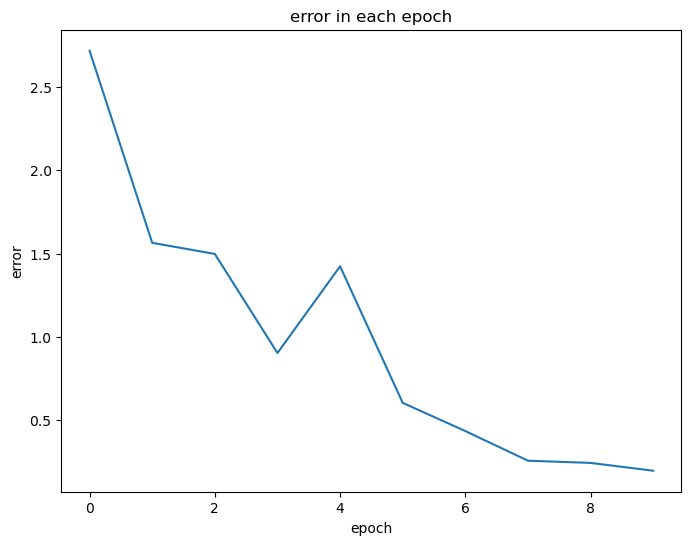

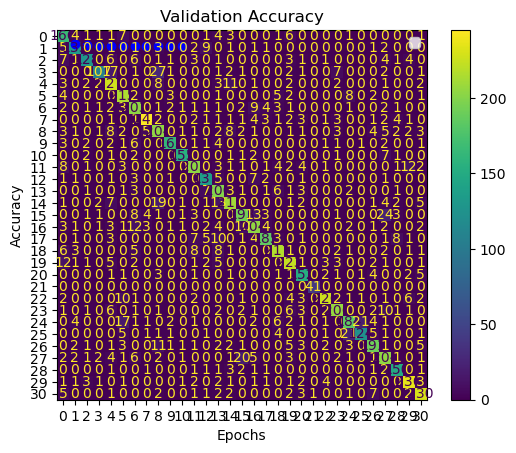

In [15]:
model = perform_test(model = model, 
                     train_data = train_data, 
                     test_data = valid_data, 
                     batch_size = batch_size, 
                     num_epochs = num_epochs, 
                     criterion = criterion, 
                     optimizer = optimizer, 
                     scheduler = scheduler,
                     device = DEVICE,
                     all_classes = classes_index,
                     trans_mode = True)

## Approaches tests

In [ ]:
# TODO

## Augmentation tests

In [ ]:
# TODO

## Hyperparametres tests

In [ ]:
# TODO